In [1]:
import sys

sys.path.insert(0, "../")

import numpy as np
from mdu.eval.eval_utils import load_pickle
from mdu.data.constants import DatasetName
from collections import defaultdict
from mdu.data.data_utils import split_dataset_indices
from mdu.unc.multidimensional_uncertainty import (
    compute_all_uncertainties,
    UncertaintyEstimator,
)
from configs.uncertainty_measures_configs import (
    MAHALANOBIS_AND_BAYES_RISK,
    EXCESSES_DIFFERENT_INSTANTIATIONS,
    EXCESSES_DIFFERENT_APPROXIMATIONS,
    BAYES_DIFFERENT_APPROXIMATIONS,
    BAYES_DIFFERENT_INSTANTIATIONS,
    BAYES_RISK_AND_BAYES_RISK,
    SINGLE_MEASURE,
)

UNCERTAINTY_MEASURES = MAHALANOBIS_AND_BAYES_RISK  # + BAYES_RISK_AND_BAYES_RISK + EXCESSES_DIFFERENT_INSTANTIATIONS

/home/nkotelevskii/github/multidimensional_uncertainty/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ENSEMBLE_GROUPS = [
    [0, 1, 2, 3, 4],
    [5, 6, 7, 8, 9],
    [10, 11, 12, 13, 14],
    [15, 16, 17, 18, 19],
]

In [3]:
ind_dataset = DatasetName.CIFAR10.value
ood_dataset = DatasetName.TINY_IMAGENET.value

results = defaultdict(list)

In [4]:
for group in ENSEMBLE_GROUPS:
    all_ind_logits = []
    all_ood_logits = []
    for model_id in group:
        ind_res = load_pickle(
            f"../model_weights/{ind_dataset}/checkpoints/resnet18/CrossEntropy/{model_id}/{ind_dataset}.pkl"
        )
        ood_res = load_pickle(
            f"../model_weights/{ind_dataset}/checkpoints/resnet18/CrossEntropy/{model_id}/{ood_dataset}.pkl"
        )

        logits_ind = ind_res["embeddings"]
        all_ind_logits.append(ind_res["embeddings"][None])
        all_ood_logits.append(ood_res["embeddings"][None])

    y_ind = ind_res["labels"]
    y_ood = ood_res["labels"]

In [5]:
_, train_cond_idx, calib_idx, test_idx = split_dataset_indices(
    logits_ind,
    y_ind,
    train_ratio=0.0,
    calib_ratio=0.1,
    test_ratio=0.8,
)

y_train_cond = y_ind[train_cond_idx]
y_calib = y_ind[calib_idx]

X_train_cond = np.vstack(all_ind_logits)[:, train_cond_idx, :]
X_calib = np.vstack(all_ind_logits)[:, calib_idx, :]
X_test = np.vstack(all_ind_logits)[:, test_idx, :]

X_ood = np.vstack(all_ood_logits)

In [6]:
print(X_train_cond.shape)
print(X_calib.shape)
print(X_test.shape)
print(X_ood.shape)

(5, 1000, 10)
(5, 1800, 10)
(5, 7200, 10)
(5, 10000, 10)


In [7]:
uncertainty_configs = UNCERTAINTY_MEASURES

# Initialize individual uncertainty estimators
uncertainty_estimators = []
for config in uncertainty_configs:
    estimator = UncertaintyEstimator(
        config["type"],
        print_name=config.get("print_name", None),
        **config["kwargs"],
    )
    estimator.fit(X_train_cond, y_train_cond)
    uncertainty_estimators.append(estimator)

In [8]:
uncertaunty_measures = np.vstack(
    compute_all_uncertainties(estimators=uncertainty_estimators, logits=X_calib)
).T
uncertaunty_measures_ind = np.vstack(
    compute_all_uncertainties(estimators=uncertainty_estimators, logits=X_test)
).T
uncertaunty_measures_ood = np.vstack(
    compute_all_uncertainties(estimators=uncertainty_estimators, logits=X_ood)
).T

In [9]:
uncertaunty_measures.shape

(1800, 2)

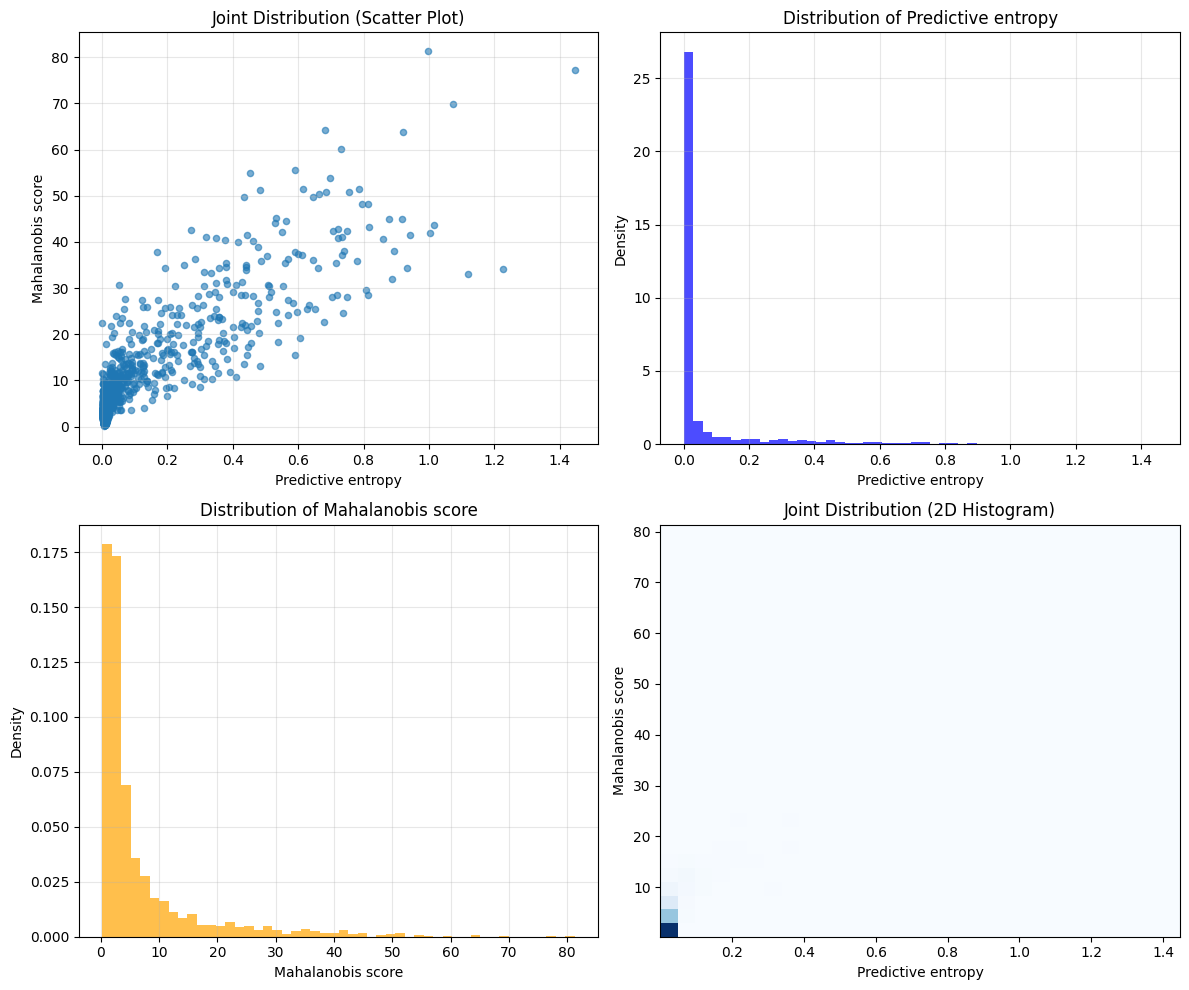

<Figure size 800x800 with 0 Axes>

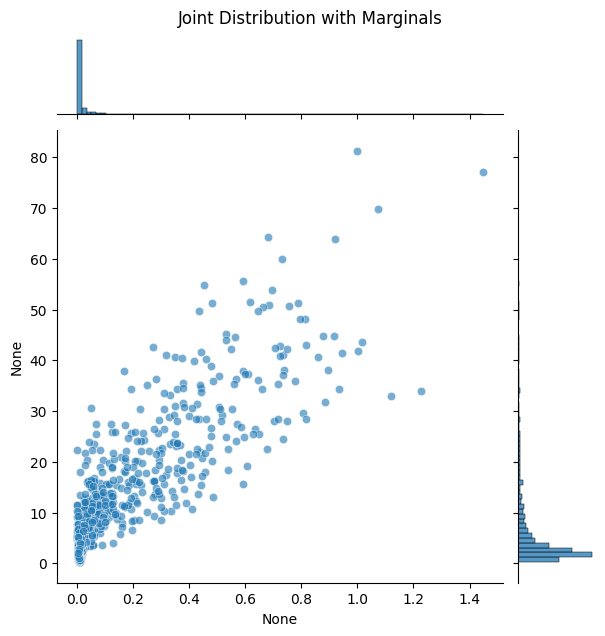

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the two uncertainty measures
uncertainty_1 = uncertaunty_measures[:, 0]
uncertainty_2 = uncertaunty_measures[:, 1]

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Scatter plot (joint distribution)
axes[0, 0].scatter(uncertainty_1, uncertainty_2, alpha=0.6, s=20)
axes[0, 0].set_xlabel(uncertainty_estimators[0].print_name)
axes[0, 0].set_ylabel(uncertainty_estimators[1].print_name)
axes[0, 0].set_title("Joint Distribution (Scatter Plot)")
axes[0, 0].grid(True, alpha=0.3)

# Histogram for first uncertainty measure
axes[0, 1].hist(uncertainty_1, bins=50, alpha=0.7, color="blue", density=True)
axes[0, 1].set_xlabel(uncertainty_estimators[0].print_name)
axes[0, 1].set_ylabel("Density")
axes[0, 1].set_title(f"Distribution of {uncertainty_estimators[0].print_name}")
axes[0, 1].grid(True, alpha=0.3)

# Histogram for second uncertainty measure
axes[1, 0].hist(uncertainty_2, bins=50, alpha=0.7, color="orange", density=True)
axes[1, 0].set_xlabel(uncertainty_estimators[1].print_name)
axes[1, 0].set_ylabel("Density")
axes[1, 0].set_title(f"Distribution of {uncertainty_estimators[1].print_name}")
axes[1, 0].grid(True, alpha=0.3)

# 2D histogram/density plot (joint distribution)
axes[1, 1].hist2d(uncertainty_1, uncertainty_2, bins=30, cmap="Blues")
axes[1, 1].set_xlabel(uncertainty_estimators[0].print_name)
axes[1, 1].set_ylabel(uncertainty_estimators[1].print_name)
axes[1, 1].set_title("Joint Distribution (2D Histogram)")

plt.tight_layout()
plt.show()

# Additional seaborn joint plot for better visualization
plt.figure(figsize=(8, 8))
sns.jointplot(x=uncertainty_1, y=uncertainty_2, kind="scatter", alpha=0.6)
plt.suptitle("Joint Distribution with Marginals", y=1.02)
plt.show()

In [11]:
from typing import Tuple, Optional, Dict, Any
from scipy.special import betainc as _betainc


# import numpy as np
class EntropicMKRanks:
    """
    Entropic OT (balanced, ε>0) from empirical source μ_X to a discrete target
    sampled from one of:
      - "ball": Uniform on unit d-ball (center-outward MK ranks; scalar rank = ||û|| ∈ [0,1])
      - "exp" : Product of independent Exponential(λ_j) on R_+^d
      - "beta": Product of independent Beta(α_j, β_j) on [0,1]^d

    Fit solves Sinkhorn in the log-domain and stores the column potential g_
    and target cloud Y_. Predict maps new points out-of-sample by barycentric
    projection using the stored g_ (no re-optimization) and returns both the
    mapped points and a scalar rank in [0,1] (definition depends on target).

    Parameters
    ----------
    target : {"ball","exp","beta"}
        Reference measure.
    target_params : dict
        Parameters for the target:
          - "exp": {"rates": array_like of shape (d,) or scalar}
          - "beta": {"alpha": array_like (d,) or scalar, "beta": array_like (d,) or scalar}
          - "ball": {}  (ignored)
    eps : float
        Entropic regularization ε (>0). Smaller = crisper, larger = smoother.
    n_targets : Optional[int]
        Number of target samples; default = n_samples at fit time.
    standardize : bool
        If True, z-score features in fit and predict (improves stability).
    max_iters : int
        Max Sinkhorn iterations.
    tol : float
        Convergence tolerance on the row potential.
    random_state : Optional[int]
        RNG seed for target sampling.

    Attributes after fit
    --------------------
    mean_, scale_ : arrays of shape (d,)
        Standardization stats (or zeros/ones if standardize=False).
    dim_ : int
        Data dimension.
    Y_ : (m, d)
        Target support points used in OT.
    g_ : (m,)
        Learned column potential for the Sinkhorn solution at fit time.
    """

    def __init__(
        self,
        target: str = "ball",
        target_params: Optional[Dict[str, Any]] = None,
        eps: float = 0.25,
        n_targets: Optional[int] = None,
        standardize: bool = True,
        max_iters: int = 2000,
        tol: float = 1e-9,
        random_state: Optional[int] = None,
    ):
        self.target = target
        self.params = target_params or {}
        self.eps = float(eps)
        self.n_targets = n_targets
        self.standardize = bool(standardize)
        self.max_iters = int(max_iters)
        self.tol = float(tol)
        self.rng = np.random.default_rng(random_state)

        # learned state
        self.mean_: Optional[np.ndarray] = None
        self.scale_: Optional[np.ndarray] = None
        self.dim_: Optional[int] = None
        self.Y_: Optional[np.ndarray] = None
        self.g_: Optional[np.ndarray] = None

    # -------------------- public API --------------------

    def fit(self, X: np.ndarray) -> "EntropicMKRanks":
        X = np.asarray(X, dtype=float)
        n, d = X.shape
        self.dim_ = d

        # standardize
        if self.standardize:
            self.mean_ = X.mean(axis=0)
            self.scale_ = X.std(axis=0)
            self.scale_[self.scale_ < 1e-12] = 1.0
            Xz = (X - self.mean_) / self.scale_
        else:
            self.mean_ = np.zeros(d)
            self.scale_ = np.ones(d)
            Xz = X

        # sample target cloud
        m = int(self.n_targets) if self.n_targets is not None else n
        self.Y_ = self._sample_target(self.target, m, d, self.params)

        # Sinkhorn (log domain) to get dual potentials
        a = np.full(n, 1.0 / n)
        b = np.full(m, 1.0 / m)
        C = self._cdist_sqeuclidean(Xz, self.Y_)
        f, g = self._sinkhorn_log_balanced(a, b, C, self.eps, self.max_iters, self.tol)
        self.g_ = g
        return self

    def predict(
        self,
        X_new: np.ndarray,
        return_map: bool = False,
        return_plan_rows: bool = False,
    ) -> (
        np.ndarray
        | Tuple[np.ndarray, np.ndarray]
        | Tuple[np.ndarray, np.ndarray, np.ndarray]
    ):
        """
        Out-of-sample mapping and scalar ranks for new points.

        Returns
        -------
        rank : (k,) array in [0,1]
            Scalar "rank" (definition depends on target).
        If return_map:
            Uhat : (k, d) barycentric images on the target space.
        If return_plan_rows:
            W : (k, m) soft row couplings (each row sums to 1).
        """
        self._check_is_fitted()
        X_new = np.asarray(X_new, dtype=float)
        Xz = (X_new - self.mean_) / self.scale_

        C_new = self._cdist_sqeuclidean(Xz, self.Y_)  # (k, m)
        L = (self.g_[None, :] - C_new) / max(self.eps, 1e-12)  # log-weights
        L -= L.max(axis=1, keepdims=True)  # stabilize
        W = np.exp(L)
        W /= W.sum(axis=1, keepdims=True)

        Uhat = W @ self.Y_  # barycentric image
        rank = self._scalar_rank_from_target(self.target, Uhat, self.params)

        if return_map and return_plan_rows:
            return rank, Uhat, W
        elif return_map:
            return rank, Uhat
        elif return_plan_rows:
            return rank, W
        else:
            return rank

    def fit_predict(self, X: np.ndarray, **predict_kwargs):
        self.fit(X)
        return self.predict(X, **predict_kwargs)

    # -------------------- internals --------------------

    @staticmethod
    def _cdist_sqeuclidean(A: np.ndarray, B: np.ndarray) -> np.ndarray:
        A2 = np.sum(A**2, axis=1, keepdims=True)
        B2 = np.sum(B**2, axis=1, keepdims=True).T
        return A2 + B2 - 2.0 * (A @ B.T)

    @staticmethod
    def _logsumexp(M: np.ndarray, axis: int) -> np.ndarray:
        m = np.max(M, axis=axis, keepdims=True)
        out = np.log(np.sum(np.exp(M - m), axis=axis, keepdims=True)) + m
        return out.squeeze(axis=axis)

    def _sinkhorn_log_balanced(
        self,
        a: np.ndarray,
        b: np.ndarray,
        C: np.ndarray,
        eps: float,
        max_iters: int,
        tol: float,
    ) -> Tuple[np.ndarray, np.ndarray]:
        n, m = C.shape
        f = np.zeros(n)
        g = np.zeros(m)
        log_a = np.log(a + 1e-300)
        log_b = np.log(b + 1e-300)
        inv_eps = 1.0 / max(eps, 1e-12)

        for _ in range(max_iters):
            f_prev = f.copy()
            M = (f[:, None] + g[None, :] - C) * inv_eps
            f += eps * (log_a - self._logsumexp(M, axis=1))
            M = (f[:, None] + g[None, :] - C) * inv_eps
            g += eps * (log_b - self._logsumexp(M, axis=0))
            if np.max(np.abs(f - f_prev)) < tol:
                break
        return f, g

    # ---- target sampling ----

    def _sample_target(
        self, target: str, m: int, d: int, params: Dict[str, Any]
    ) -> np.ndarray:
        target = target.lower()
        if target == "ball":
            # Uniform on unit d-ball
            Z = self.rng.normal(size=(m, d))
            Z /= np.linalg.norm(Z, axis=1, keepdims=True) + 1e-12
            radii = self.rng.random(m) ** (1.0 / d)
            return Z * radii[:, None]

        elif target == "exp":
            # Product of independent exponentials with rates λ_j > 0
            lam = params.get("rates", 1.0)
            lam = np.asarray(lam, dtype=float)
            if lam.size == 1:
                lam = np.full(d, lam.item())
            assert lam.shape == (d,) and np.all(lam > 0), (
                "rates must be shape (d,) and >0"
            )
            U = self.rng.random((m, d))
            # Inverse CDF: y_j = -ln(1-U)/λ_j
            return -np.log(1.0 - U) / lam[None, :]

        elif target == "beta":
            # Product of independent Beta(α_j, β_j) on [0,1]
            alpha = params.get("alpha", 1.0)
            beta = params.get("beta", 1.0)
            alpha = np.asarray(alpha, dtype=float)
            beta = np.asarray(beta, dtype=float)
            if alpha.size == 1:
                alpha = np.full(d, alpha.item())
            if beta.size == 1:
                beta = np.full(d, beta.item())
            assert alpha.shape == (d,) and beta.shape == (d,), (
                "alpha,beta must be shape (d,)"
            )
            assert np.all(alpha > 0) and np.all(beta > 0), "alpha,beta must be >0"
            Y = np.empty((m, d))
            for j in range(d):
                Y[:, j] = self.rng.beta(alpha[j], beta[j], size=m)
            return Y

        else:
            raise ValueError(
                f"Unknown target '{target}' (use 'ball', 'exp', or 'beta')."
            )

    # ---- scalar rank for coloring/ordering ----

    def _scalar_rank_from_target(
        self, target: str, Uhat: np.ndarray, params: Dict[str, Any]
    ) -> np.ndarray:
        target = target.lower()
        if target == "ball":
            # classic MK rank radius
            return np.linalg.norm(Uhat, axis=1)

        elif target == "exp":
            # product of marginal exponential CDFs: Π_j (1 - exp(-λ_j y_j))
            lam = params.get("rates", 1.0)
            lam = np.asarray(lam, dtype=float)
            if lam.size == 1:
                lam = np.full(Uhat.shape[1], lam.item())
            lam = lam[None, :]  # (1, d)
            F = 1.0 - np.exp(-np.clip(Uhat, 0.0, None) * lam)
            return np.prod(F, axis=1)

        elif target == "beta":
            # product of marginal Beta CDFs: Π_j I_{y_j}(α_j, β_j)
            alpha = params.get("alpha", 1.0)
            beta = params.get("beta", 1.0)
            alpha = np.asarray(alpha, dtype=float)
            beta = np.asarray(beta, dtype=float)
            if alpha.size == 1:
                alpha = np.full(Uhat.shape[1], alpha.item())
            if beta.size == 1:
                beta = np.full(Uhat.shape[1], beta.item())
            # betainc(a,b,x) is the regularized incomplete beta (CDF)
            F = np.empty_like(Uhat)
            # clip to [0,1] for safety
            Y = np.clip(Uhat, 0.0, 1.0)
            for j in range(Uhat.shape[1]):
                F[:, j] = _betainc(alpha[j], beta[j], Y[:, j])
            return np.prod(F, axis=1)

        else:
            raise ValueError(f"Unknown target '{target}'.")

    # ---- checks ----

    def _check_is_fitted(self):
        if self.Y_ is None or self.g_ is None or self.dim_ is None:
            raise RuntimeError("Call fit(X) before predict().")

In [12]:
# from typing import Tuple, Optional
# import numpy as np


# class EntropicMKRanks:
#     """
#     Fit entropic OT (balanced, ε>0) from an empirical source distribution μ_X
#     to a discrete approximation of Unif(B_d(0,1)) and provide out-of-sample
#     MK ranks for new points via barycentric projection.

#     - Fit:   solve for dual potentials (f, g) with Sinkhorn in log domain.
#     - Predict (OOS): for new x, compute weights p_j(x) ∝ exp((g_j - c(x, y_j))/ε),
#                      then  û(x) = Σ_j p_j(x) y_j ;  MK rank ρ(x) = ||û(x)|| ∈ [0,1].

#     Parameters
#     ----------
#     eps : float
#         Entropic regularization ε. Smaller = crisper / less smooth, but harder numerically.
#     n_targets : Optional[int]
#         Number of target points on the unit d-ball. Default = n_samples at fit time.
#     standardize : bool
#         If True, z-score each feature: (x - mean) / (std + 1e-12). Applied in fit + predict.
#     max_iters : int
#         Max Sinkhorn iterations.
#     tol : float
#         Convergence tolerance on the row potential f.
#     random_state : Optional[int]
#         Seed for target grid sampling.
#     """

#     def __init__(
#         self,
#         eps: float = 0.25,
#         n_targets: Optional[int] = None,
#         standardize: bool = True,
#         max_iters: int = 2000,
#         tol: float = 1e-9,
#         random_state: Optional[int] = None,
#     ):
#         self.eps = float(eps)
#         self.n_targets = n_targets
#         self.standardize = bool(standardize)
#         self.max_iters = int(max_iters)
#         self.tol = float(tol)
#         self.rng = np.random.default_rng(random_state)

#         # Learned state after fit
#         self.mean_: Optional[np.ndarray] = None
#         self.scale_: Optional[np.ndarray] = None
#         self.dim_: Optional[int] = None
#         self.Y_: Optional[np.ndarray] = None  # (m, d) target points on unit ball
#         self.g_: Optional[np.ndarray] = None  # (m,) column potential

#     # ---------- public API ----------

#     def fit(self, X: np.ndarray) -> "EntropicMKRanks":
#         """
#         Fit entropic OT from X to a discrete uniform grid on the unit d-ball.

#         X : (n, d) array
#         """
#         X = np.asarray(X, dtype=float)
#         n, d = X.shape
#         self.dim_ = d

#         # Preprocess
#         if self.standardize:
#             self.mean_ = X.mean(axis=0)
#             self.scale_ = X.std(axis=0)
#             self.scale_[self.scale_ < 1e-12] = 1.0  # avoid divide-by-zero
#             Xz = (X - self.mean_) / self.scale_
#         else:
#             self.mean_ = np.zeros(d)
#             self.scale_ = np.ones(d)
#             Xz = X

#         # Target grid on the unit d-ball
#         m = int(self.n_targets) if self.n_targets is not None else n
#         self.Y_ = self._sample_uniform_ball(m, d)

#         # Balanced Sinkhorn (log-domain) to get potentials f, g
#         a = np.full(n, 1.0 / n)
#         b = np.full(m, 1.0 / m)
#         C = self._cdist_sqeuclidean(Xz, self.Y_)  # (n, m)
#         f, g = self._sinkhorn_log_balanced(a, b, C, self.eps, self.max_iters, self.tol)
#         self.g_ = g  # store column potential for OOS

#         return self

#     def predict(
#         self,
#         X_new: np.ndarray,
#         return_map: bool = False,
#     ) -> np.ndarray | Tuple[np.ndarray, np.ndarray]:
#         """
#         Out-of-sample MK ranks for new points.

#         Returns
#         -------
#         rho : (k,) array of MK rank radii in [0, 1].
#         If return_map=True, also returns Uhat : (k, d), the barycentric images on the ball.
#         """
#         self._check_is_fitted()
#         X_new = np.asarray(X_new, dtype=float)
#         Xz = (X_new - self.mean_) / self.scale_

#         C_new = self._cdist_sqeuclidean(Xz, self.Y_)              # (k, m)
#         L = (self.g_[None, :] - C_new) / max(self.eps, 1e-12)     # log-weights
#         L -= L.max(axis=1, keepdims=True)                         # stabilize
#         W = np.exp(L)
#         W /= W.sum(axis=1, keepdims=True)                         # soft row couplings

#         Uhat = W @ self.Y_                                        # barycentric images
#         rho = np.linalg.norm(Uhat, axis=1)                        # MK radii

#         return (rho, Uhat) if return_map else rho

#     def fit_predict(
#         self, X: np.ndarray, return_map: bool = False
#     ) -> np.ndarray | Tuple[np.ndarray, np.ndarray]:
#         """Convenience: fit on X and return ranks for X."""
#         self.fit(X)
#         return self.predict(X, return_map=return_map)

#     # ---------- internals ----------

#     @staticmethod
#     def _cdist_sqeuclidean(A: np.ndarray, B: np.ndarray) -> np.ndarray:
#         A2 = np.sum(A**2, axis=1, keepdims=True)      # (n, 1)
#         B2 = np.sum(B**2, axis=1, keepdims=True).T    # (1, m)
#         return A2 + B2 - 2.0 * (A @ B.T)

#     def _sinkhorn_log_balanced(
#         self,
#         a: np.ndarray,
#         b: np.ndarray,
#         C: np.ndarray,
#         eps: float,
#         max_iters: int,
#         tol: float,
#     ) -> Tuple[np.ndarray, np.ndarray]:
#         """
#         Balanced Sinkhorn in log domain.
#         Returns row & column potentials (f, g) such that
#         P = exp((f[:,None] + g[None,:] - C) / eps) approximately matches marginals a, b.
#         """
#         n, m = C.shape
#         f = np.zeros(n)
#         g = np.zeros(m)
#         log_a = np.log(a + 1e-300)
#         log_b = np.log(b + 1e-300)
#         inv_eps = 1.0 / max(eps, 1e-12)

#         for _ in range(max_iters):
#             f_prev = f.copy()
#             # Update f
#             M = (f[:, None] + g[None, :] - C) * inv_eps
#             f += eps * (log_a - self._logsumexp(M, axis=1))
#             # Update g
#             M = (f[:, None] + g[None, :] - C) * inv_eps
#             g += eps * (log_b - self._logsumexp(M, axis=0))
#             if np.max(np.abs(f - f_prev)) < tol:
#                 break

#         return f, g

#     @staticmethod
#     def _logsumexp(M: np.ndarray, axis: int) -> np.ndarray:
#         m = np.max(M, axis=axis, keepdims=True)
#         out = np.log(np.sum(np.exp(M - m), axis=axis, keepdims=True)) + m
#         return out.squeeze(axis=axis)

#     def _sample_uniform_ball(self, m: int, d: int) -> np.ndarray:
#         """
#         Sample m points ~ Unif(B_d(0,1)) by normal directions + radius^(1/d).
#         (This serves as the discrete 'grid' for MK ranks.)
#         """
#         Z = self.rng.normal(size=(m, d))
#         Z /= (np.linalg.norm(Z, axis=1, keepdims=True) + 1e-12)   # directions on S^{d-1}
#         radii = self.rng.random(m) ** (1.0 / d)                    # radius distribution
#         return Z * radii[:, None]

#     def _check_is_fitted(self):
#         if self.Y_ is None or self.g_ is None or self.dim_ is None:
#             raise RuntimeError("Call fit(X) before predict().")


In [13]:
eot = EntropicMKRanks(eps=0.15, target="beta")  # exp, ball, beta

In [14]:
eot.fit(X=uncertaunty_measures)

In [15]:
ranks_ind = eot.predict(uncertaunty_measures_ind)
ranks_ood = eot.predict(uncertaunty_measures_ood)

In [16]:
from sklearn.metrics import roc_auc_score


def compute_roc_auc(ranks_ind, ranks_ood):
    ranks = np.concatenate([ranks_ind, ranks_ood])
    labels = np.concatenate([np.zeros(ranks_ind.shape[0]), np.ones(ranks_ood.shape[0])])
    return roc_auc_score(labels, ranks)

In [17]:
for name, (ind_, ood_) in [
    *[
        (
            uncertainty_estimators[i].print_name,
            (uncertaunty_measures_ind[:, i], uncertaunty_measures_ood[:, i]),
        )
        for i in range(len(uncertainty_estimators))
    ],
    ("multidimensional", (ranks_ind, ranks_ood)),
]:
    print(name, compute_roc_auc(ind_, ood_))

Predictive entropy 0.9121779861111111
Mahalanobis score 0.9090997222222222
multidimensional 0.9152544583333333


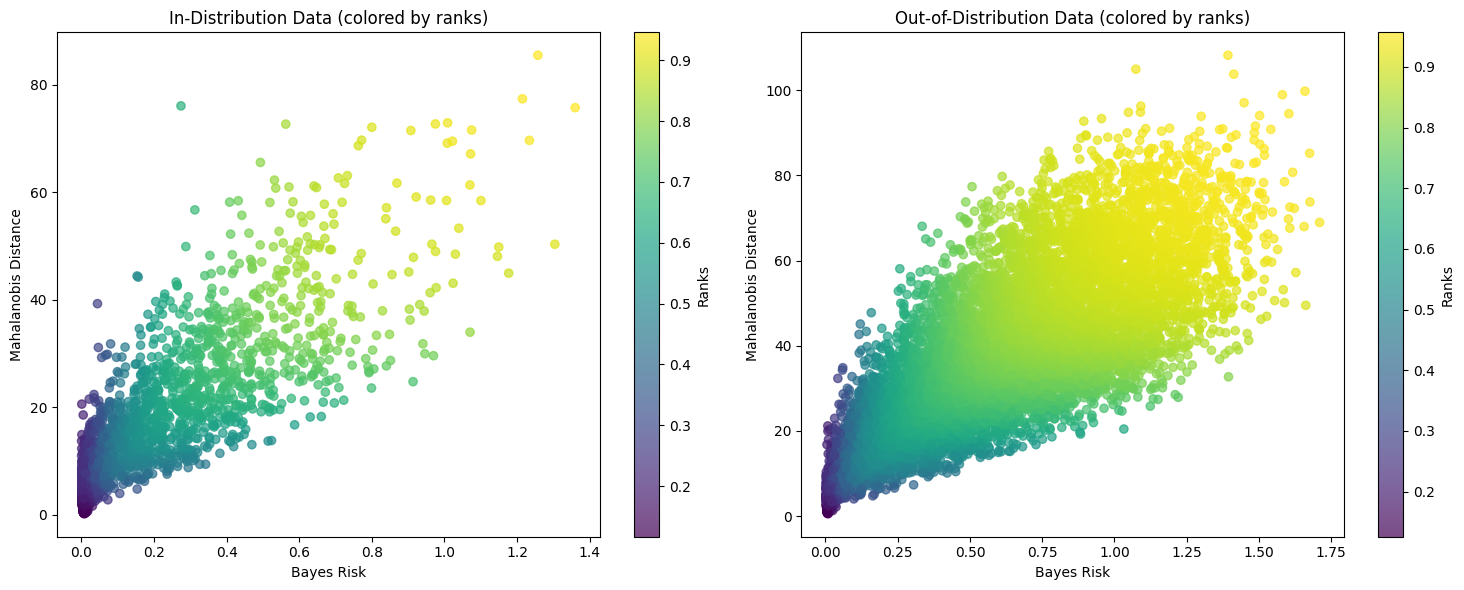

In [18]:
import matplotlib.pyplot as plt

# Create subplots for both visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for in-distribution data
scatter1 = ax1.scatter(
    uncertaunty_measures_ind[:, 0],
    uncertaunty_measures_ind[:, 1],
    c=ranks_ind,
    cmap="viridis",
    alpha=0.7,
)
ax1.set_xlabel("Bayes Risk")
ax1.set_ylabel("Mahalanobis Distance")
ax1.set_title("In-Distribution Data (colored by ranks)")
plt.colorbar(scatter1, ax=ax1, label="Ranks")

# Plot for out-of-distribution data
scatter2 = ax2.scatter(
    uncertaunty_measures_ood[:, 0],
    uncertaunty_measures_ood[:, 1],
    c=ranks_ood,
    cmap="viridis",
    alpha=0.7,
)
ax2.set_xlabel("Bayes Risk")
ax2.set_ylabel("Mahalanobis Distance")
ax2.set_title("Out-of-Distribution Data (colored by ranks)")
plt.colorbar(scatter2, ax=ax2, label="Ranks")

plt.tight_layout()
plt.show()